# Wine Prediction Competition
- Julian Stiefkens
- Daniela Ojeda

In [310]:
# Data manipulation and visualization
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Machine learning tools
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from scipy.stats import mode

import warnings
warnings.filterwarnings("ignore")

## Data Exploration

- Load the dataset and display the first few rows.
- Plot a heatmap to visualize feature correlations.

In [311]:
url = "https://raw.githubusercontent.com/Demosthene-OR/Student-AI-and-Data-Management/main/Wine%20Classification%20Competition/"
wines = pd.read_csv(url+"train.csv", sep=',', index_col='id')
wines_validation = pd.read_csv(url+"test.csv", sep=',', index_col='id')
wines.head()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
id,,,,,,,,,,,,
0,6.019691,0.283766,0.400783,11.156173,0.048657,53.127097,145.824182,0.993666,3.086785,0.586505,10.988825,7
1,5.437448,0.518034,0.161372,2.536892,0.035596,33.554664,130.242893,0.988448,3.197995,0.538773,13.140516,8
2,7.114223,0.250095,0.395592,2.339770,0.036894,30.010317,124.521478,0.990797,3.281557,0.427115,12.164164,8
3,7.189613,0.273295,0.348988,1.610184,0.053887,31.170454,147.854496,0.991959,3.176231,0.462251,10.691332,5
4,6.549686,0.312809,0.345302,6.225016,0.046103,27.470335,91.230439,0.991688,3.283407,0.599576,12.026913,7


<Axes: >

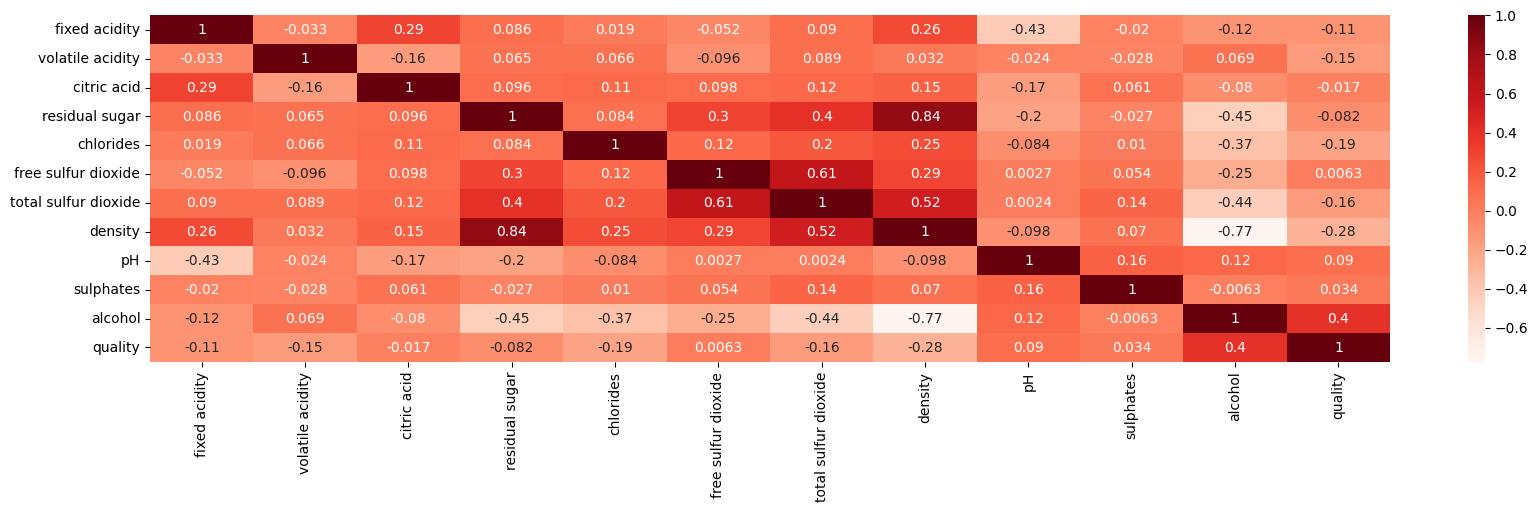

In [312]:
import matplotlib
matplotlib.pyplot.figure(figsize=(20, 4.5))
sns.heatmap(wines.corr(), annot=True, cmap="Reds")

- Split the dataset into training and test sets.
- Scale the features for better model performance.

## Data Preparation

In [313]:
y_train = wines['quality']
corr = wines.corr()
to_drop = [col for col in corr.columns if abs(corr[col].corr(y_train)) < 0.05]
X_train = wines.drop('quality', axis=1)
X_train = X_train.drop(to_drop, axis=1)

X_test = wines_validation

In [314]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

## Random Forest

In [315]:
import lightgbm as lgb
from sklearn.model_selection import RandomizedSearchCV, train_test_split
from sklearn.metrics import accuracy_score

# --- Definimos el modelo base ---
lgb_clf = lgb.LGBMClassifier(random_state=42)

# --- Rango de parámetros a probar ---
param_grid = {
    'n_estimators': [100, 200, 300, 400, 500],
    'max_depth': [3, 5, 7, 10, 15, -1],   # -1 significa sin límite
    'learning_rate': [0.01, 0.05, 0.1, 0.2],
    'num_leaves': [15, 31, 63, 127],      # controla la complejidad del árbol
    'min_child_samples': [5, 10, 20, 30], # mínimo de datos por hoja
    'subsample': [0.6, 0.8, 1.0],         # para reducir overfitting
    'colsample_bytree': [0.6, 0.8, 1.0]   # para reducir overfitting
}

# --- RandomizedSearchCV ---
search = RandomizedSearchCV(
    estimator=lgb_clf,
    param_distributions=param_grid,
    n_iter=30,          # cantidad de combinaciones a probar
    scoring='accuracy',
    cv=5,
    verbose=1,
    n_jobs=-1,
    random_state=42
)

# --- Entrenar la búsqueda ---
search.fit(X_train, y_train)

# --- Mejor modelo ---
best_lgb = search.best_estimator_
print("Mejores parámetros:", search.best_params_)

# --- Evaluar ---
y_pred = best_lgb.predict(X_test)


Fitting 5 folds for each of 30 candidates, totalling 150 fits
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000600 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2805
[LightGBM] [Info] Number of data points in the train set: 3898, number of used features: 11
[LightGBM] [Info] Start training from score -4.834232
[LightGBM] [Info] Start training from score -3.298406
[LightGBM] [Info] Start training from score -1.246242
[LightGBM] [Info] Start training from score -0.817558
[LightGBM] [Info] Start training from score -1.708604
[LightGBM] [Info] Start training from score -3.211973
[LightGBM] [Info] Start training from score -5.377847
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with pos

In [316]:
y_pred_df = pd.DataFrame(y_pred, index=wines_validation.index, columns=['quality'])
y_pred_df.head(5)

,quality
id,
3898,6
3899,8
3900,6
3901,5
3902,5


In [317]:
from google.colab import files

y_pred_df.to_csv('wine_predictions.csv')
files.download('wine_predictions.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>